In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from pmdarima import auto_arima


In [3]:
df = pd.read_csv("Daily_Public_Transport_Passenger_Journeys_by_Service_Type_20250603.csv")

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index("Date")
df = df.sort_index()

df.head()


,Local Route,Light Rail,Peak Service,Rapid Route,School,Other
Date,,,,,,
2019-07-01,15987,9962,407,21223,3715,NaN
2019-07-02,16895,10656,409,21715,3993,NaN
2019-07-03,16613,10658,427,22025,3638,NaN
2019-07-04,16604,10445,437,21868,3576,NaN
2019-07-05,16040,10532,400,20697,2856,NaN


In [4]:
service_cols = ['Local Route', 'Light Rail', 'Peak Service', 'Rapid Route', 'School']


In [5]:
# Reindex to daily frequency
df = df.asfreq("D")

# Interpolate missing values
df = df.interpolate(method="linear")


In [6]:
#remove outliers using IQR

def remove_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

for col in service_cols:
    df[col] = remove_outliers(df[col])


In [7]:

#smooth the time series
df_smooth = df.rolling(window=3, min_periods=1).mean()


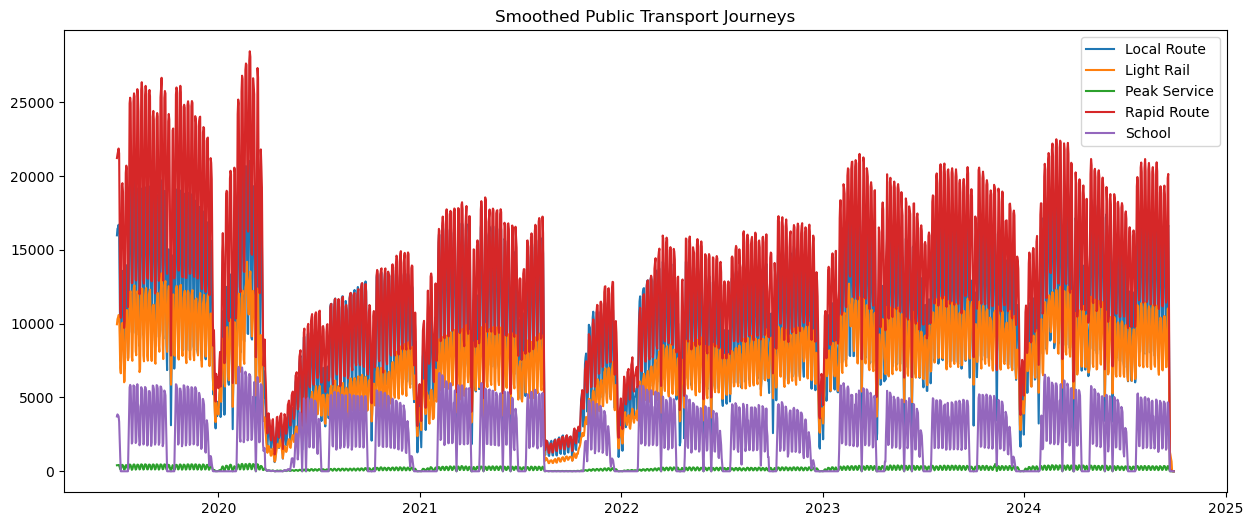

In [8]:
#visualize the cleaned data
plt.figure(figsize=(15, 6))
for col in service_cols:
    plt.plot(df_smooth[col], label=col)
plt.title("Smoothed Public Transport Journeys")
plt.legend()
plt.show()


In [9]:
def sarima_build(series):
    model = auto_arima(
        series,
        seasonal=True,
        m=7,
        trace=True,
        suppress_warnings=True,
        stepwise=True,
        error_action="ignore",
        max_p=3, max_q=3,       
        max_P=2, max_Q=2,       
        max_d=1, max_D=1        
    )
    model_fit = model.fit(series)
    return model_fit, model.order, model.seasonal_order



In [10]:

#Forecast for 7 Days Using SARIMA + Log Transform
future_preds = {}
sarima_orders = {}

for col in service_cols:
    print(f"\n Training SARIMA for: {col}")

    series = df_smooth[col]
    
    # Log transform
    log_series = np.log1p(series)

    # Fit SARIMA
    model, order, seasonal_order = sarima_build(log_series)
    sarima_orders[col] = (order, seasonal_order)

    # Forecast 7 days
    forecast_log = model.predict(n_periods=7)
    forecast = np.expm1(forecast_log)

    future_preds[col] = forecast



 Training SARIMA for: Local Route
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=-1098.428, Time=2.64 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1489.152, Time=0.14 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-312.477, Time=0.49 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=437.365, Time=0.42 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1487.441, Time=0.10 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=inf, Time=2.50 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=-391.170, Time=1.97 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=-1057.492, Time=3.93 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=-1094.418, Time=3.74 sec
 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=1.66 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=inf, Time=3.93 sec
 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=-764.834, Time=3.01 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=-1141.955, Time=4.20 sec
 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=3.94 sec
 ARIMA(2,1,1)(2

In [11]:
forecast_table = pd.DataFrame(future_preds)
forecast_table.index = [f"Day {i+1}" for i in range(7)]
forecast_table


,Local Route,Light Rail,Peak Service,Rapid Route,School
Day 1,2.096762,0.480727,-0.435670,7.263767,0.265825
Day 2,3.515490,-0.163212,-0.352000,10.709475,1.282442
Day 3,5.049402,0.037699,-0.239818,14.432411,2.542767
Day 4,4.891959,-0.019169,-0.116282,14.692493,4.040320
Day 5,4.234294,-0.425861,-0.254794,13.671019,5.334052
Day 6,2.638901,-0.542660,-0.504221,10.296520,6.332278
Day 7,0.589925,-0.631708,-0.911030,4.770469,5.572791


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

evaluation_results = {}

for col in service_cols:
    
    # True last 7 days
    true_values = df_smooth[col].iloc[-7:]
    
    # Model predicted last 7 days
    preds = future_preds[col]
    
    # Metrics
    mae = mean_absolute_error(true_values, preds)
    rmse = mean_squared_error(true_values, preds, squared=False)
    mape = np.mean(np.abs((true_values - preds) / true_values)) * 100
    
    evaluation_results[col] = {
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape
    }

# Convert to table
metrics_table = pd.DataFrame(evaluation_results).T
metrics_table


,MAE,RMSE,MAPE (%)
Local Route,18.473800,22.920284,NaN
Light Rail,382.752026,590.787025,NaN
Peak Service,0.544831,0.570022,NaN
Rapid Route,17.545320,25.115986,NaN
School,3.443967,3.888230,NaN
